In [309]:
import glob
from statistics import mean
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
from scipy.stats import gaussian_kde

In [295]:
loaded_files = set()
file_label = {}
delta_over_hamming = {}       
delta_over_hamming_mean = {}
survival_rate = {}
time_for_food = {}
time_for_food_mean = {}

In [338]:
files = glob.glob('policy*.txt')
for file in {f for f in files if f not in loaded_files}:
    loaded_files.add(file)
    with open(file) as f:
        content = f.readlines()
    lines = [x.strip() for x in content]
    # Label
    file_label[file] = lines[0]
    delta_over_hamming[file] = dict((i, []) for i in range(1, 900)) # don't use 'set()' - arrays are close enough to mutlisets
    survival_rate[file] = dict((i, 0) for i in range(1, 900))
    time_for_food[file] = dict((i, []) for i in range(1, 900))
    # Times
    for line in lines[1:]:
        haming_dist_for_food = {}
        time_at_food = {}
        delta_for_food = {}
        split = line.strip().split()
        food = 1
        prevTime = 0
        for entry in split:
            survival_rate[file][food] += 1
            fragment = entry[1:-1].split(',')
            haming_dist_for_food[food] = int(fragment[0])
            time_at_food[food] = int(fragment[1])
            delta_for_food[food] = time_at_food[food] - prevTime
            
            time_for_food[file][food].append(time_at_food[food])
            delta_over_hamming[file][food].append(delta_for_food[food] - haming_dist_for_food[food])
            #print(delta_over_hamming[file][food])
            
            prevTime = time_at_food[food]
            food += 1
    delta_over_hamming_mean[file] = {}
    time_for_food_mean[file] = {}
    for food in range(1, 900):
        if len(delta_over_hamming[file][food]) < 10:
            break
        delta_over_hamming_mean[file][food] = mean(delta_over_hamming[file][food])
        time_for_food_mean[file][food] = mean(time_for_food[file][food])
    for food in reversed(range(1, 900)):
        survival_rate[file][food] /= survival_rate[file][1]
    

In [285]:
loaded_files.remove('policy7.txt')

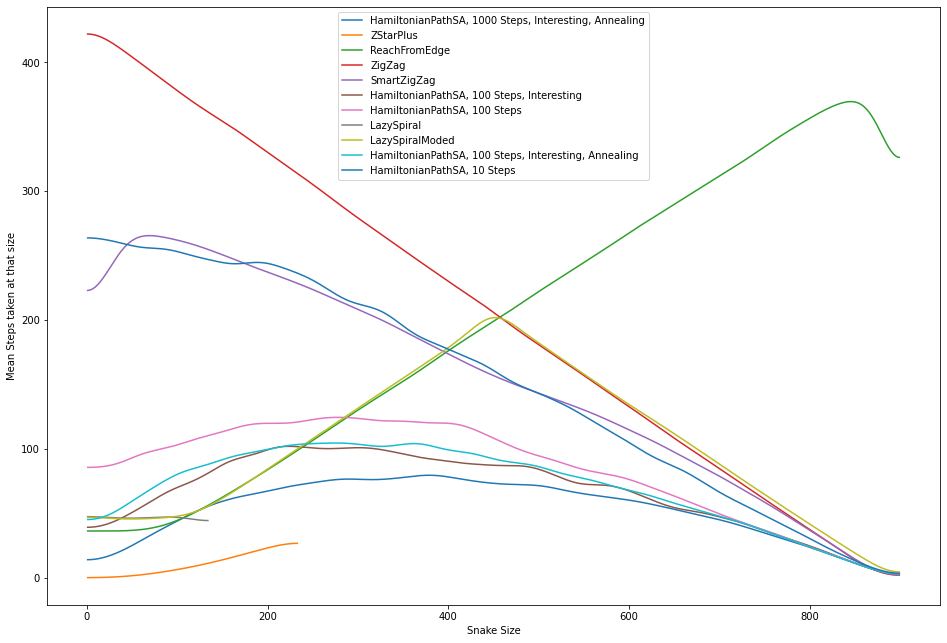

In [347]:
for file in files:
    items = len(delta_over_hamming_mean[file])
    ysmoothed = gaussian_filter1d(list(delta_over_hamming_mean[file].values())[0:items], sigma=20)
    plt.plot(np.linspace(1, items, items), ysmoothed, label = file_label[file])
    #plt.plot(np.linspace(1, items, items), delta_over_hamming_mean[file].values(), label = file_label[file])

plt.xlabel("Snake Size")
plt.ylabel("Mean Steps taken at that size")
plt.legend()
plt.rcParams["figure.figsize"] = (16,11)

plt.show()

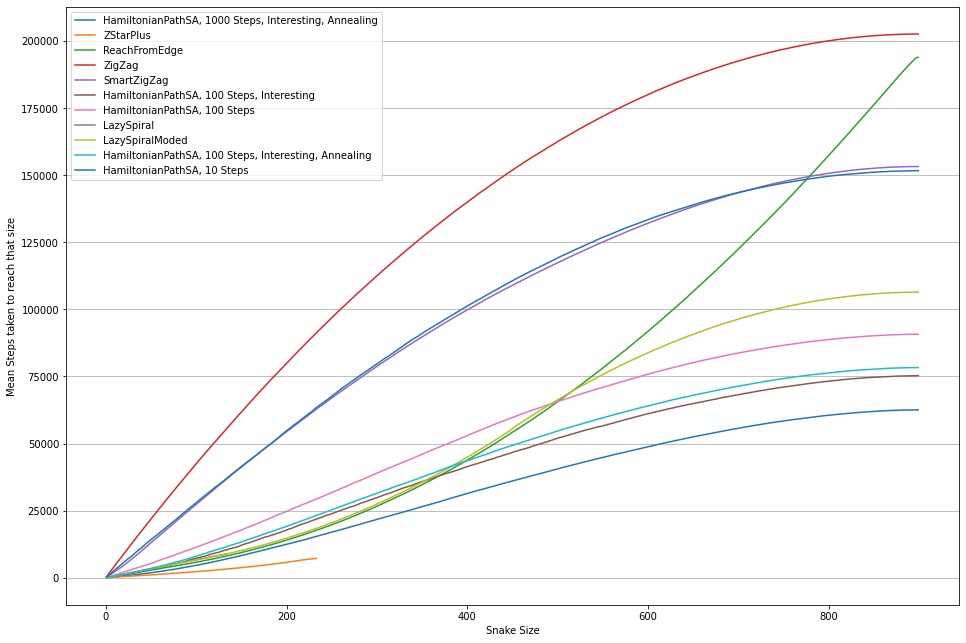

In [344]:
for file in files:
    items = len(time_for_food_mean[file])
    #ysmoothed = gaussian_filter1d(list(time_for_food_mean[file].values())[0:items], sigma=0.01)
    #plt.plot(np.linspace(1, items, items), ysmoothed, label = file_label[file])
    plt.plot(np.linspace(1, items, items), time_for_food_mean[file].values(), label = file_label[file])

plt.xlabel("Snake Size")
plt.ylabel("Mean Steps taken to reach that size")
plt.legend()
plt.rcParams["figure.figsize"] = (16,11)
plt.grid(axis = 'y')

plt.show()

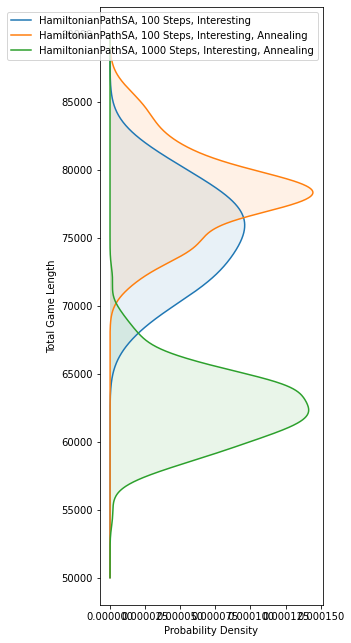

In [342]:
min_val = 50000
max_val = 90000
interesting_files = [
#    'policy6.txt',
    'policy7.txt',
    'policy8.txt',
    'policy10.txt'
]
xs = np.linspace(min_val, max_val,1000)
for file in interesting_files:
    density = gaussian_kde(time_for_food[file][899])
    
    #density.covariance_factor = lambda : 0.25
    #density._compute_covariance()
    
    plt.plot(density(xs), xs, label = file_label[file])
    plt.fill(density(xs), xs, alpha=0.1)
    
    #plt.plot(xs, means, label = "Policy "+str(i))
    #print(np.mean(data))
    #plt.plot(xs,norm.pdf(xs, np.mean(data), np.std(data, ddof=1)))

plt.rcParams["figure.figsize"] = (4,11)
plt.xlabel("Probability Density")
plt.ylabel("Total Game Length")
#plt.axes.get_xaxis().set_visible(False)
plt.legend()
plt.show()